In [ ]:
#Dataset Upload

from google.colab import files
uploaded = files.upload()


In [ ]:
# Install lifelines for survival analysis
!pip install lifelines


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 8.7 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=5c424aa7480b2621c3c94d383d8996e784cc9ea6b7577ef77c23e0bdc216edba
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


In [ ]:
# Import of libraries
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier


from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    brier_score_loss,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
)


from lifelines import KaplanMeierFitter, CoxPHFitter


import shap


import warnings
warnings.filterwarnings("ignore")


In [ ]:
# Load dataset
df = pd.read_csv("dataset.csv")

df.head()


,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,...,TopicID,QuestionID,ResponseID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3
0,2020,2020,US,United States,BRFSS,Health Status,Recent activity limitation among adults,NaN,Number,Age-adjusted Mean,...,HEA,HEA04,NaN,AGEADJMEAN,SEX,SEXF,NaN,NaN,NaN,NaN
1,2015,2019,AR,Arkansas,US Cancer DVT,Cancer,"Invasive cancer (all sites combined), incidence",NaN,Number,Number,...,CAN,CAN07,NaN,NMBR,SEX,SEXM,NaN,NaN,NaN,NaN
2,2015,2019,CA,California,US Cancer DVT,Cancer,"Cervical cancer mortality among all females, u...",NaN,Number,Number,...,CAN,CAN03,NaN,NMBR,OVERALL,OVR,NaN,NaN,NaN,NaN
3,2015,2019,CO,Colorado,US Cancer DVT,Cancer,"Invasive cancer (all sites combined), incidence",NaN,Number,Number,...,CAN,CAN07,NaN,NMBR,RACE,HIS,NaN,NaN,NaN,NaN
4,2015,2019,GA,Georgia,US Cancer DVT,Cancer,"Prostate cancer mortality among all males, und...",NaN,Number,Number,...,CAN,CAN05,NaN,NMBR,RACE,WHT,NaN,NaN,NaN,NaN


In [ ]:
# Dataset structure
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309215 entries, 0 to 309214
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   YearStart                  309215 non-null  int64  
 1   YearEnd                    309215 non-null  int64  
 2   LocationAbbr               309215 non-null  object 
 3   LocationDesc               309215 non-null  object 
 4   DataSource                 309215 non-null  object 
 5   Topic                      309215 non-null  object 
 6   Question                   309215 non-null  object 
 7   Response                   0 non-null       float64
 8   DataValueUnit              309215 non-null  object 
 9   DataValueType              309215 non-null  object 
 10  DataValue                  209196 non-null  float64
 11  DataValueAlt               209196 non-null  float64
 12  DataValueFootnoteSymbol    101716 non-null  object 
 13  DataValueFootnote          10

In [ ]:
# Summary statistics
df.describe()


,YearStart,YearEnd,Response,DataValue,DataValueAlt,LowConfidenceLimit,HighConfidenceLimit,StratificationCategory2,Stratification2,StratificationCategory3,Stratification3,LocationID,ResponseID,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3
count,309215.000000,309215.000000,0.0,2.091960e+05,2.091960e+05,188885.000000,188890.000000,0.0,0.0,0.0,0.0,309215.000000,0.0,0.0,0.0,0.0,0.0
mean,2020.012195,2020.288540,NaN,6.943569e+02,7.356701e+02,36.825051,46.030554,NaN,NaN,NaN,NaN,31.208693,NaN,NaN,NaN,NaN,NaN
std,1.530835,1.068591,NaN,1.620341e+04,1.834715e+04,65.025590,69.995643,NaN,NaN,NaN,NaN,17.798773,NaN,NaN,NaN,NaN,NaN
min,2015.000000,2019.000000,NaN,0.000000e+00,0.000000e+00,0.000000,0.000000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
25%,2019.000000,2019.000000,NaN,1.240000e+01,1.240000e+01,9.100000,14.000000,NaN,NaN,NaN,NaN,17.000000,NaN,NaN,NaN,NaN,NaN
50%,2020.000000,2020.000000,NaN,2.700000e+01,2.700000e+01,19.500000,29.200000,NaN,NaN,NaN,NaN,31.000000,NaN,NaN,NaN,NaN,NaN
75%,2021.000000,2021.000000,NaN,5.780000e+01,5.780000e+01,40.300000,54.300000,NaN,NaN,NaN,NaN,45.000000,NaN,NaN,NaN,NaN,NaN
max,2022.000000,2022.000000,NaN,2.925456e+06,2.925456e+06,1427.000000,1485.900000,NaN,NaN,NaN,NaN,78.000000,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Check missing values
df.isnull().sum()


,0
YearStart,0
YearEnd,0
LocationAbbr,0
LocationDesc,0
DataSource,0
Topic,0
Question,0
Response,309215
DataValueUnit,0
DataValueType,0


In [ ]:
df[['Topic', 'Question', 'Response', 'DataValue', 'YearStart', 'YearEnd']].head()


,Topic,Question,Response,DataValue,YearStart,YearEnd
0,Health Status,Recent activity limitation among adults,NaN,2.9,2020,2020
1,Cancer,"Invasive cancer (all sites combined), incidence",NaN,9537.0,2015,2019
2,Cancer,"Cervical cancer mortality among all females, u...",NaN,486.0,2015,2019
3,Cancer,"Invasive cancer (all sites combined), incidence",NaN,2880.0,2015,2019
4,Cancer,"Prostate cancer mortality among all males, und...",NaN,519.0,2015,2019


In [ ]:
df['DataValue'] = pd.to_numeric(df['DataValue'], errors='coerce')


In [ ]:
# Combine all stratification columns safely
df['combined_stratification'] = (
    df['Stratification1'].astype(str) + ' ' +
    df['Stratification2'].astype(str) + ' ' +
    df['Stratification3'].astype(str)
)


In [ ]:
young_adults = df[
    df['combined_stratification'].str.contains(
        '18|24|25|34', case=False, na=False
    )
]


In [ ]:
if young_adults.shape[0] == 0:
    print("⚠️ Age stratification not found — using full dataset")
    young_adults = df.copy()


In [ ]:
young_adults['DataValue'] = pd.to_numeric(
    young_adults['DataValue'], errors='coerce'
)


In [ ]:
# Check DataValue distribution
young_adults['DataValue'].describe()


,DataValue
count,7603.000000
mean,20.935341
std,18.584278
min,1.000000
25%,5.900000
50%,16.100000
75%,28.900000
max,85.500000


In [ ]:
threshold = young_adults['DataValue'].median()

young_adults['sustained_exercise'] = np.where(
    young_adults['DataValue'] >= threshold, 1, 0
)

# Verify class balance
print(young_adults['sustained_exercise'].value_counts())


sustained_exercise
0    4335
1    3808
Name: count, dtype: int64


In [ ]:
# Recommendation adherence proxy (normalised)
young_adults['recommendation_adherence_score'] = (
    young_adults['DataValue'] /
    young_adults['DataValue'].max()
)

# App engagement proxy (response density per location)
young_adults['app_engagement_score'] = (
    young_adults.groupby('LocationID')['ResponseID']
    .transform('count')
)

# Study duration (years)
young_adults['study_duration'] = (
    young_adults['YearEnd'] - young_adults['YearStart']
)

# Encode location as numeric
young_adults['location_encoded'] = (
    young_adults['LocationID'].astype('category').cat.codes
)


In [ ]:
#Distribution of Class

features = [
    'recommendation_adherence_score',
    'app_engagement_score',
    'study_duration',
    'location_encoded'
]

X = young_adults[features]
y = young_adults['sustained_exercise']

# Sanity check
print("X shape:", X.shape)
print("Class distribution:\n", y.value_counts())


X shape: (8143, 4)
Class distribution:
 sustained_exercise
0    4335
1    3808
Name: count, dtype: int64


In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)


In [ ]:
#Model Training and testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 5700
Testing samples: 2443


In [ ]:
# Logistic Regression Classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, f1_score, brier_score_loss

log_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced'
)

log_model.fit(X_train, y_train)

y_pred_log = log_model.predict(X_test)
y_prob_log = log_model.predict_proba(X_test)[:, 1]

print("LOGISTIC REGRESSION RESULTS")
print(classification_report(y_test, y_pred_log))
print("AUROC:", roc_auc_score(y_test, y_prob_log))
print("F1 Score:", f1_score(y_test, y_pred_log))
print("Brier Score:", brier_score_loss(y_test, y_prob_log))


LOGISTIC REGRESSION RESULTS
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1301
           1       1.00      0.96      0.98      1142

    accuracy                           0.98      2443
   macro avg       0.98      0.98      0.98      2443
weighted avg       0.98      0.98      0.98      2443

AUROC: 0.9985845456344371
F1 Score: 0.9771607702642185
Brier Score: 0.021904122483366237


In [ ]:
# Random Forest Classification

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced'
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

print("RANDOM FOREST RESULTS")

print("AUROC:", roc_auc_score(y_test, y_prob_rf))
print(classification_report(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("Brier Score:", brier_score_loss(y_test, y_prob_rf))


RANDOM FOREST RESULTS
AUROC: 0.9981467172631588
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1301
           1       1.00      0.99      1.00      1142

    accuracy                           1.00      2443
   macro avg       1.00      1.00      1.00      2443
weighted avg       1.00      1.00      1.00      2443

F1 Score: 0.9969284774023695
Brier Score: 0.0026934204110136556


In [ ]:
# XGBoost Classification

from xgboost import XGBClassifier

scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight
)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("XGBOOST RESULTS")
print(classification_report(y_test, y_pred_xgb))
print("AUROC:", roc_auc_score(y_test, y_prob_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb))
print("Brier Score:", brier_score_loss(y_test, y_prob_xgb))


XGBOOST RESULTS
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1301
           1       0.99      0.98      0.99      1142

    accuracy                           0.99      2443
   macro avg       0.99      0.99      0.99      2443
weighted avg       0.99      0.99      0.99      2443

AUROC: 0.9989732403068635
F1 Score: 0.9872077635641817
Brier Score: 0.00931354680942294


In [ ]:
# MLP Classification

from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    max_iter=500,
    random_state=42
)

mlp_model.fit(X_train, y_train)

y_pred_mlp = mlp_model.predict(X_test)
y_prob_mlp = mlp_model.predict_proba(X_test)[:, 1]

print("MLP NEURAL NETWORK RESULTS")
print(classification_report(y_test, y_pred_mlp))
print("AUROC:", roc_auc_score(y_test, y_prob_mlp))
print("F1 Score:", f1_score(y_test, y_pred_mlp))
print("Brier Score:", brier_score_loss(y_test, y_prob_mlp))


MLP NEURAL NETWORK RESULTS
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1301
           1       1.00      0.98      0.99      1142

    accuracy                           0.99      2443
   macro avg       0.99      0.99      0.99      2443
weighted avg       0.99      0.99      0.99      2443

AUROC: 0.999286551770092
F1 Score: 0.9920564872021183
Brier Score: 0.007002474731033311


In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auroc_scores = []

for train_idx, val_idx in cv.split(X_scaled, y):
    X_tr, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = LogisticRegression(
        max_iter=1000,
        class_weight='balanced'
    )
    model.fit(X_tr, y_tr)

    y_val_prob = model.predict_proba(X_val)[:, 1]
    auroc_scores.append(roc_auc_score(y_val, y_val_prob))

print("Mean 5-Fold CV AUROC:", np.mean(auroc_scores))


Mean 5-Fold CV AUROC: 0.9990843613026834


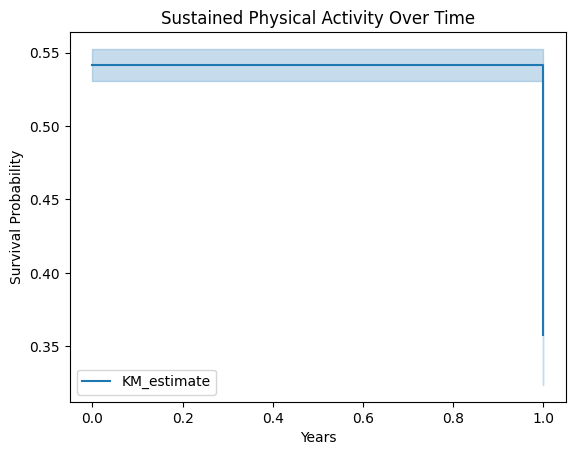

In [ ]:
#Survival probability with sustained Phyiscal Activity over time

from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

young_adults['duration'] = young_adults['YearEnd'] - young_adults['YearStart']
young_adults['event'] = young_adults['sustained_exercise']

kmf = KaplanMeierFitter()
kmf.fit(
    durations=young_adults['duration'],
    event_observed=young_adults['event']
)

kmf.plot_survival_function()
plt.title("Sustained Physical Activity Over Time")
plt.xlabel("Years")
plt.ylabel("Survival Probability")
plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler

cox_df = young_adults[
    [
        'duration',
        'event',
        'recommendation_adherence_score'  # keep strongest predictor
    ]
].dropna()


In [ ]:
scaler = StandardScaler()
cox_df[['recommendation_adherence_score']] = scaler.fit_transform(
    cox_df[['recommendation_adherence_score']]
)


In [ ]:
from lifelines import CoxPHFitter

cph = CoxPHFitter(penalizer=0.1)  # L2 regularisation

cph.fit(
    cox_df,
    duration_col='duration',
    event_col='event'
)

cph.print_summary()


<lifelines.CoxPHFitter: fitted with 7603 total observations, 3795 right-censored observations>
             duration col = 'duration'
                event col = 'event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 7603
number of events observed = 3808
   partial log-likelihood = -30928.90
         time fit was run = 2025-12-17 05:46:05 UTC

---
                                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                       
recommendation_adherence_score  0.75      2.11      0.01            0.72            0.77                2.06                2.16

                                cmp to     z      p  -log2(p)
covariate                                                    
recommendation_adherence_score    0.00 62.52 <0.005       inf
---
Concordance = 1.00
Partial AIC = 61859.80
log-likelihood ratio test = 3276.33 on 1 df
-log2(p) of ll-ratio test = inf

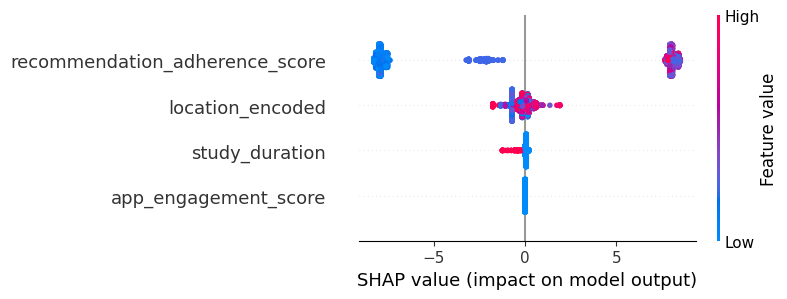

In [ ]:
#SHAP Value

import shap

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(
    shap_values,
    X_test,
    feature_names=features
)


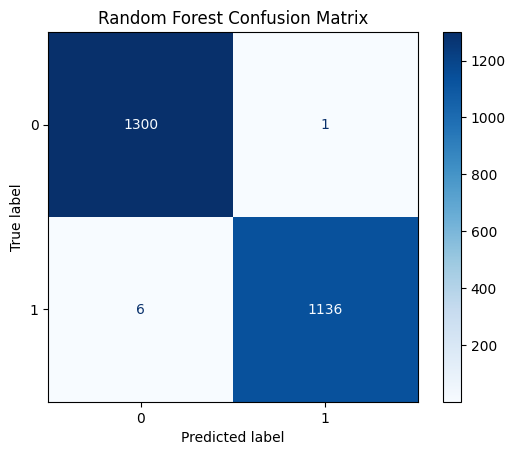

In [ ]:
#Confusion Matrix of RandomF Forest

cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Random Forest Confusion Matrix")
plt.show()


<Figure size 800x600 with 0 Axes>

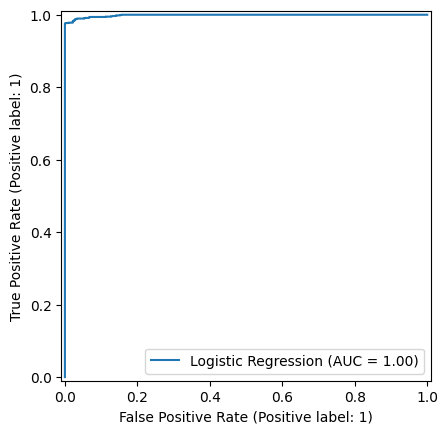

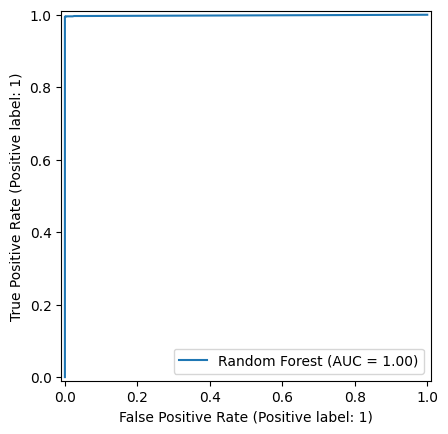

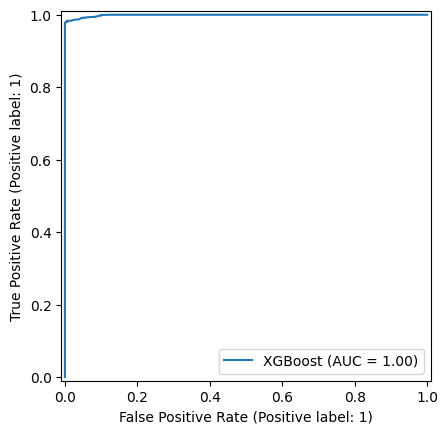

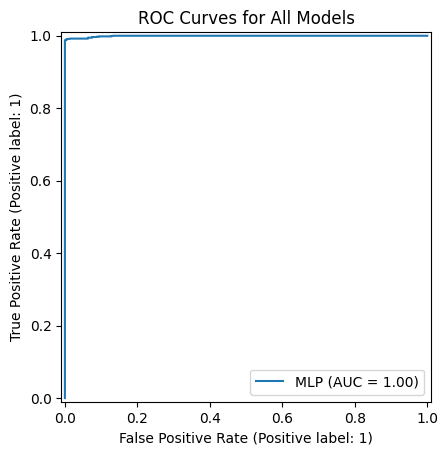

In [ ]:
#ROC Curve of all Models

plt.figure(figsize=(8,6))
RocCurveDisplay.from_estimator(log_model, X_test, y_test, name="Logistic Regression")
RocCurveDisplay.from_estimator(rf_model, X_test, y_test, name="Random Forest")
RocCurveDisplay.from_estimator(xgb_model, X_test, y_test, name="XGBoost")
RocCurveDisplay.from_estimator(mlp_model, X_test, y_test, name="MLP")
plt.title("ROC Curves for All Models")
plt.show()